<a href="https://colab.research.google.com/github/desi-C/How-Much-Are-We-Worth/blob/main/Akram_Desiree_Michael_CSc_447_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **How Much Are We Worth?**



<a href="https://colab.research.google.com/github/desi-C/How-Much-Are-We-Worth/blob/main/salary_predictor_csc_447_final_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




Akram Uddin, Desiree Caceres, Michael Franklin

Professor Wu

CSc 44700

20 May 2025

In order for the code to properly run you must use the csv file that was provided



1.   Download the csv file and remember its location
2.   Back in the notebook environment click the "Files" icon on the left sidebar
represented by the folder image
3. Then click the first icon that popus up which should be "Upload to session storage"
4. After clicking that go to where you placed your csv file and open it
5. Now the code should be fully operational



## Table of contents

This notebook analyzes a salary dataset of approximately 6700 entries with the goal of predicting salary using various machine learning models. The analysis is structured as follows:

1.  **Exploratory Data Analysis (EDA):**
    *   Data Cleaning and Preprocessing
2.  **Data Visualization:**
    *   Creating charts and graphs for our data
    *   Visualizing any correlations or patterns there might be to
      draw inferences from
3.  **Feature Engineering:**
    *   Creation of new features
    *   Transformation of existing features
4.  **Fairness and Bias Analysis:**
    *   Gender pay gap analysis
    *   Evaluation of demographic parity and disparate impact
    *   Use of Theil Index to measure salary inequality
5.  **Model Development and Evaluation:**
    *   Linear Regression
    *   Other advanced regression models (e.g., Random Forest, KNN and Neural Network)
    *   Model performance evaluation using metrics such as Mean Squared Error (MSE), R-squared, etc.
6.  **Limitations and Future Work**

Note that all analysis results depend on the dataset. The results may not reflect the facts in the real world.

<hr>

## Data Reading and Preprocessing



In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import entropy
# Simple linear regression for salary prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
salary_data = pd.read_csv('./Salary_Data.csv')
salary_data.head()
#salary_data.describe()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### Null data

Removed Null data

In [2]:
salary_data.info()
salary_data[salary_data.isnull().any(axis=1)]
salary_data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


### Inconsistent values

I found that different values (e.g. PhD and phD) were used to refer to the same degree in the 'Education Level' column. Thus, I made these values consistent.

In [3]:
salary_data['Education Level'].value_counts()

,count
Education Level,
Bachelor's Degree,2265
Master's Degree,1572
PhD,1368
Bachelor's,756
High School,448
Master's,288
phD,1


In [4]:
def UnifyEducationLevel(s):
    for e in ['Bachelor', 'Master', 'PhD']:
        if e.lower() in s.lower(): return e
    return s

salary_data['Education Level'] = salary_data['Education Level'].apply(UnifyEducationLevel)
salary_data['Education Level'].value_counts()

,count
Education Level,
Bachelor,3021
Master,1860
PhD,1369
High School,448


### Duplicate entries

The presence of duplicate entries was assessed using ``` duplicated().sum() ```, revealing 4912 instances of replication within the dataset. Further investigation via ``` pivot_table()``` quantified the extent of these duplications. While the occurrence of identical data points across multiple respondents (e.g., 45 individuals sharing the same profile in a survey of approximately 6700 participants) remains plausible, a decision was made to retain these entries. This choice prioritized the preservation of dataset size, acknowledging that duplicate removal would have resulted in a substantial reduction (approximately 70%) of the available data for analysis.

In [5]:
salary_data.duplicated().sum()
salary_data.pivot_table(index = ['Age', 'Gender', 'Education Level',  'Job Title', 'Years of Experience', 'Salary'], aggfunc ='size').sort_values().tail(10)
#salary_data.drop_duplicates()  # choose to keep them since it is possible to have duplicate data

,,,,,,0
Age,Gender,Education Level,Job Title,Years of Experience,Salary,
30.0,Female,PhD,Data Scientist,7.0,185000.0,33
26.0,Male,Bachelor,Data Analyst,3.0,130000.0,35
25.0,Male,Bachelor,Product Manager,1.0,60000.0,36
29.0,Female,Master,Data Scientist,6.0,180000.0,37
27.0,Male,Bachelor,Software Engineer,4.0,140000.0,37
33.0,Female,Master,Product Manager,11.0,198000.0,38
32.0,Male,Bachelor,Software Engineer,8.0,190000.0,39
24.0,Female,High School,Receptionist,0.0,25000.0,45
32.0,Male,Bachelor,Product Manager,7.0,120000.0,45


<hr>

## Part 1. Demographic Overview of Survey Participants

This section provides an initial examination of the survey's participant demographics. Key observations include:

*   The majority of respondents are relatively young, with ages concentrated around 35 years or less.
*   Salaries reported by participants predominantly fall within the range of $50,000 to $200,000.
*   The sample exhibits a slight gender imbalance, with a modestly higher representation of male participants compared to their female counterparts.
*   Approximately 45% of participants hold a Bachelor's degree, while around 30% possess a Master's degree.
*   The survey appears to have a notable focus on individuals employed within the Information Technology (IT) sector. The most frequently reported job titles include Software Engineer, Data Scientist, and Software Engineer Manager.

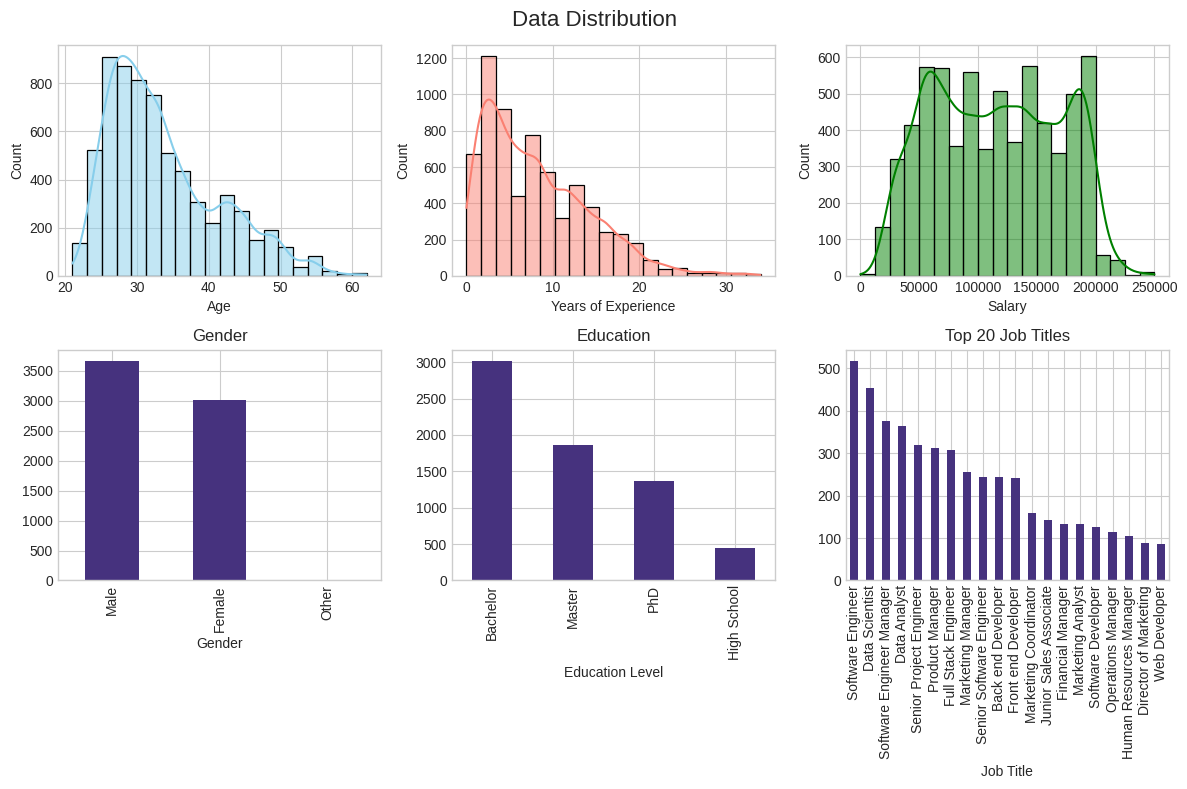

In [6]:
salary_data['Age'] = salary_data['Age'].astype('int')
salary_data['Years of Experience'] = salary_data['Years of Experience'].astype('int')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

sns.histplot(salary_data['Age'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
sns.histplot(salary_data['Years of Experience'], bins=20, kde=True, ax=axes[0, 1], color='salmon')
sns.histplot(salary_data['Salary'], bins=20, kde=True, ax=axes[0, 2], color='green')

salary_data['Gender'].value_counts().plot(kind='bar', ax=axes[1, 0], title='Gender')
salary_data['Education Level'].value_counts().plot(kind='bar', ax=axes[1, 1], title='Education')
salary_data['Job Title'].value_counts()[:20].plot(kind='bar', ax=axes[1, 2], title='Top 20 Job Titles')

fig.suptitle('Data Distribution', fontsize=16)
plt.tight_layout()

<hr>

## Part 2. Relationship between a Single Factor and the Salary

### Factors: gender, education, age, and YoE

Observations:
* The salary of male participants is a little bit higher than that of female.
* The salary of participants with a higher degree is higher. (Phd > Master > Bachelor > High School)
* The salary roughly increases as the age and YoE increase.

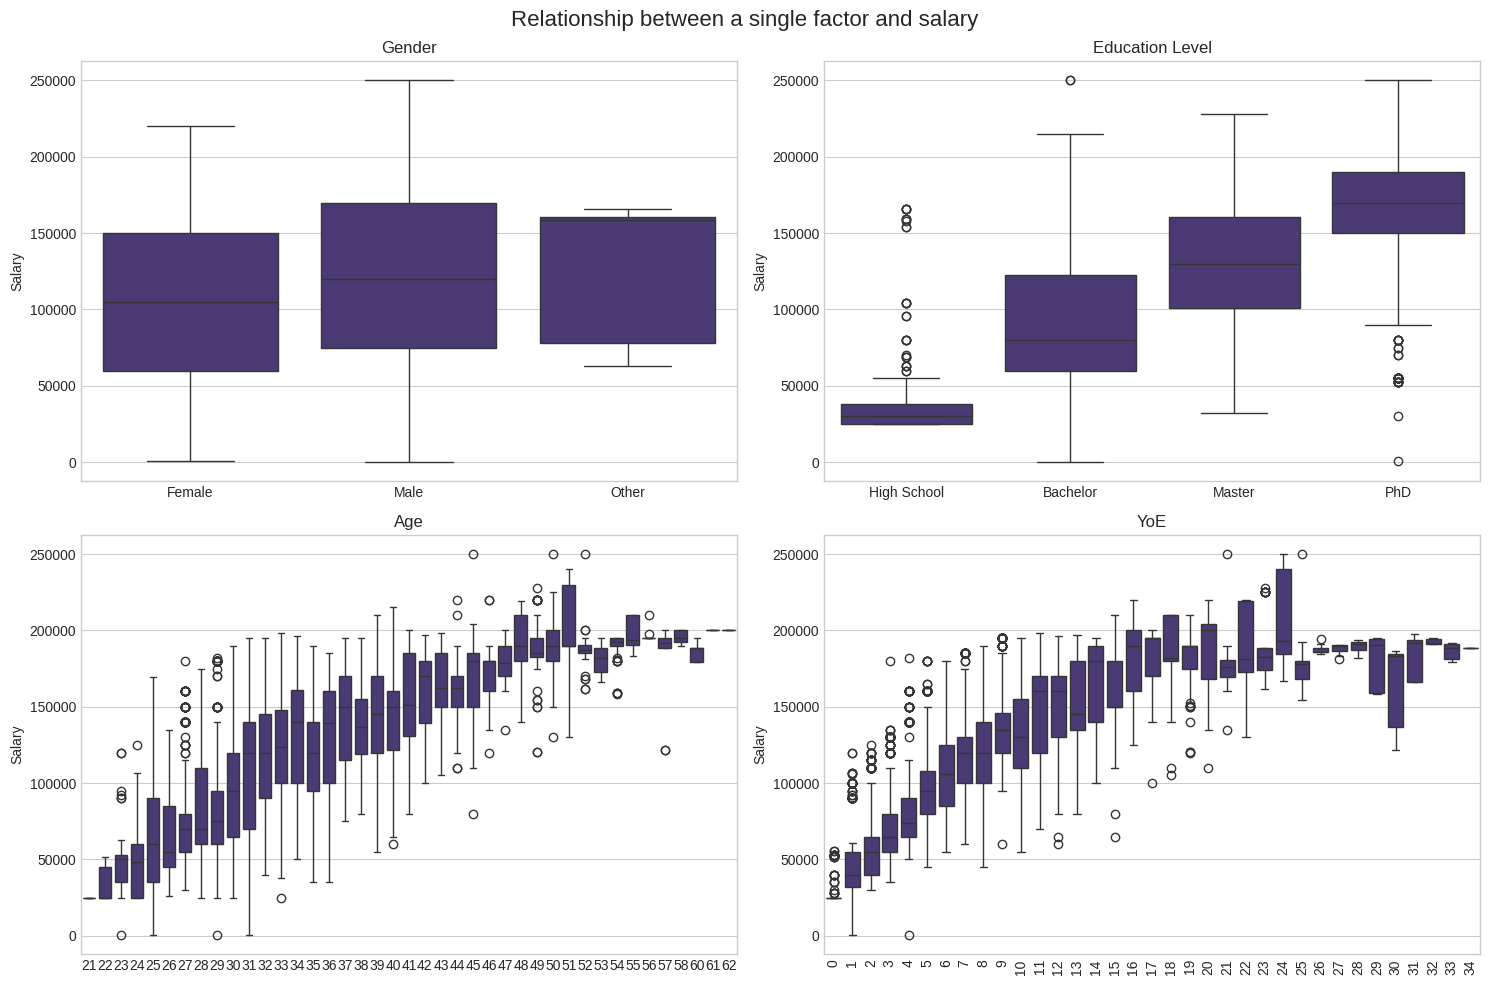

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

xfactor = "Gender"
g = sns.boxplot(x=xfactor, y="Salary", data=salary_data, ax=axes[0, 0], order=salary_data.groupby(xfactor)['Salary'].median().sort_values().index)
g.set(title='Gender', xlabel=None)

xfactor = "Education Level"
g = sns.boxplot(x=xfactor, y="Salary", data=salary_data, ax=axes[0, 1], order=salary_data.groupby(xfactor)['Salary'].median().sort_values().index)
g.set(title='Education Level', xlabel=None)

xfactor = "Age"
plt.xticks(rotation=90)
g = sns.boxplot(x=xfactor, y="Salary", ax=axes[1, 0], data=salary_data)
g.set(title='Age', xlabel=None)

xfactor = "Years of Experience"
plt.xticks(rotation=90)
g = sns.boxplot(x=xfactor, y="Salary", ax=axes[1, 1], data=salary_data)
g.set(title='YoE', xlabel=None)

fig.suptitle('Relationship between a single factor and salary', fontsize=16)
plt.tight_layout()

### In-depth question: Does age really positively affect the salary?

We can expect that:
(1) the `salary` and the `YoE` have a positive correlation and
(2) the `YoE` and the `age` have a positive correlation.

However, do the `age` and the `salary` also have a positive correlation?

Let's fix the `YoE` and look into the relationship between the `age` and the `salary`.

Oh, it reveals that the positive correlation between the `age` and the `salary` could be brought by the two previous positive correlation (`age`-`YoE` + `YoE`-`salary` => `age`-`salary`).

The truth is that, when the `YoE` is the same, the `age` and the `salary` are negatively correlated.

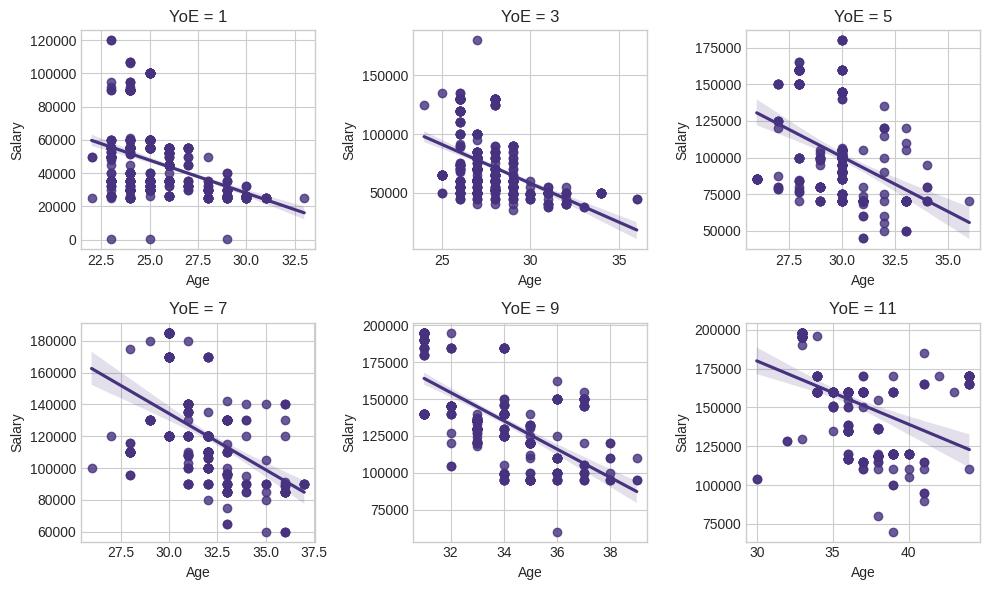

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
xfactor = "Age"

for i, yoe in enumerate([1, 3, 5, 7, 9, 11]):
    g = sns.regplot(x=xfactor, y="Salary", ax=axes[i//3, i%3], data=salary_data[salary_data['Years of Experience']==yoe])
    g.set(title=f'YoE = {yoe}')

plt.tight_layout()

### Last factor: job title

The next figure shows the most popular jobs and the salary range of these jobs in the decreasing order of the median of salary. The top five highest-paid jobs are:
1. senior project engineer
1. software engineer manager
1. data scientist
1. director of marketing
1. senior software engineer

The media values of salary of the top five jobs are all above 150,000.

Text(0.5, 1.0, 'Most Popular 20 Jobs in the Survey & the Salary Range')

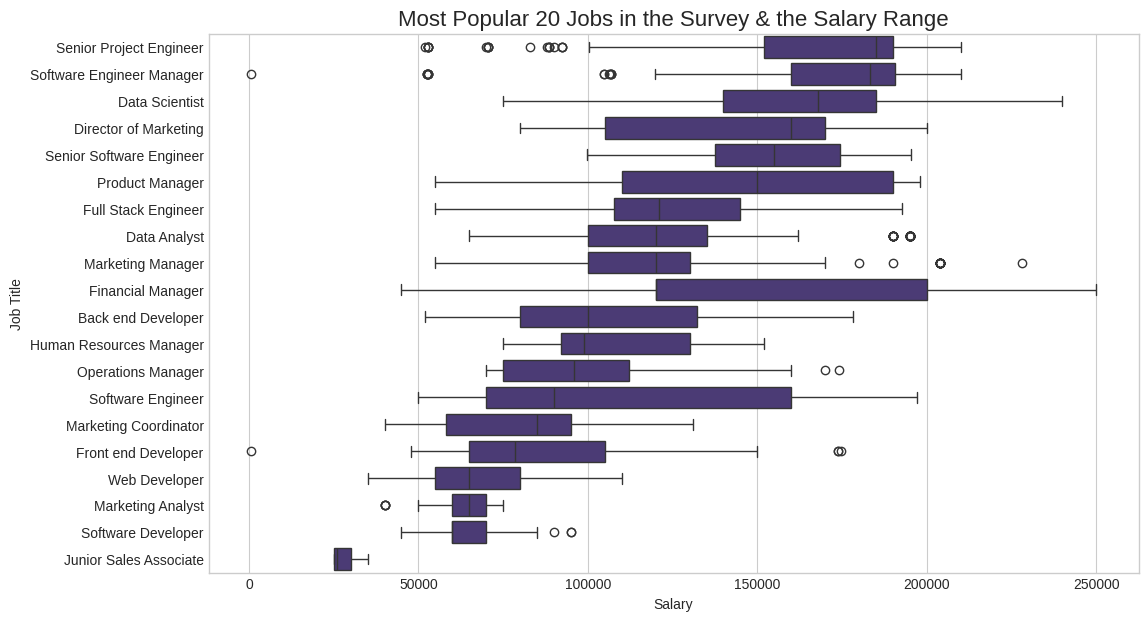

In [9]:
num_pop_jobs = 20
pop_jobs = salary_data['Job Title'].value_counts()[:num_pop_jobs].index
pop_jobs_data = salary_data[salary_data['Job Title'].isin(pop_jobs)]

plt.figure(figsize=(12, 7))
sns.boxplot(y="Job Title", x="Salary", data=pop_jobs_data,
            order=pop_jobs_data.groupby('Job Title')['Salary'].median().sort_values(ascending=False).index)
plt.title(f'Most Popular {num_pop_jobs} Jobs in the Survey & the Salary Range', fontsize=16)

<hr>

## Part 3. Salary vs. Years of Experience: Gender, Education Level, and Job Titles

Prior analyses have indicated a positive correlation between salary and Years of Experience (YoE), where increased YoE corresponds to higher salaries. This section investigates potential salary growth trajectories in relation to gender, education level, and job title. It is important to note that this analysis does not track individual salary progression over time; rather, it examines cross-sectional data, comparing salary levels across individuals with varying YoE.

Initial observations from the subsequent figures suggest the following:

1.  Salary growth rates appear consistent across genders.
2.  Salary growth rates exhibit minimal variation across different education levels, with the rate for PhD holders appearing marginally lower.

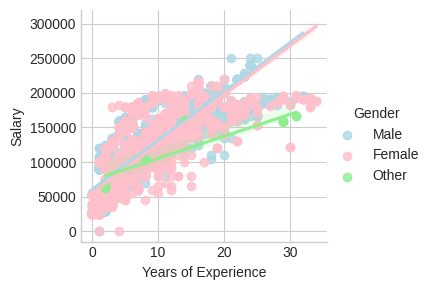

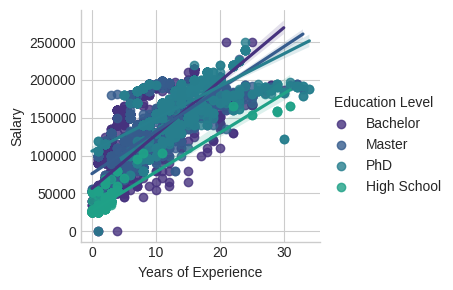

In [10]:
custom_palette = {'Male': 'lightblue', 'Female': 'pink', 'Other': 'lightgreen'}
sns.lmplot(data=salary_data, x='Years of Experience', y='Salary', hue='Gender', palette=custom_palette, height=3, aspect=1.2)
sns.lmplot(data=salary_data, x='Years of Experience', y='Salary', hue='Education Level', height=3, aspect=1.2)

Next, the relationship between Years of Experience (YoE) and salary was examined for the most prevalent job titles. Linear regression models were fitted to the data for each job title, and the job titles were then ranked in descending order based on the magnitude of their slope coefficients.

Key findings include:

1. Software Engineer, Financial Manager, and Product Manager exhibited the highest rates of salary growth with respect to YoE.

1. Senior Software Engineer, Software Engineer Manager, and Data Scientist demonstrated the lowest rates of salary growth relative to YoE, despite being among the highest-paid positions identified in prior analyses.)

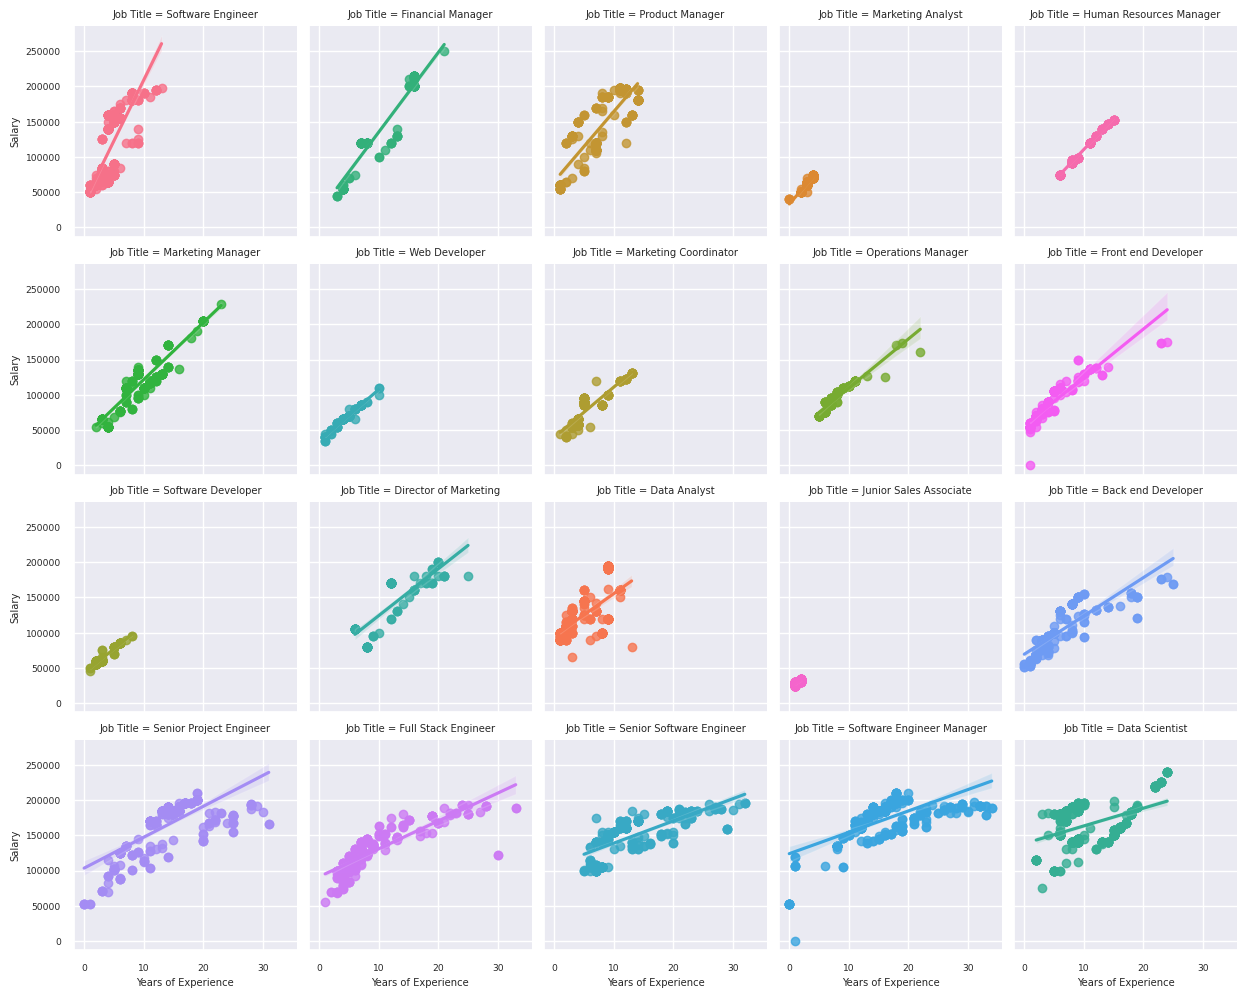

In [11]:
from scipy import stats

num_pop_jobs = 20
pop_jobs = salary_data['Job Title'].value_counts()[:num_pop_jobs].index

job_salary_slopes = []
for j in pop_jobs:
    job_data = salary_data[salary_data['Job Title']==j]
    slope, intercept, r_value, pv, se = stats.linregress(job_data['Years of Experience'], job_data['Salary'])
    job_salary_slopes.append([j, slope, intercept])
job_salary_slopes.sort(key = lambda x: x[1], reverse=True)
job_order = [e[0] for e in job_salary_slopes]

pop_jobs_data = salary_data[salary_data['Job Title'].isin(pop_jobs)]
sns.set(font_scale=0.6)
sns.lmplot(data=pop_jobs_data, x='Years of Experience', y='Salary', hue='Job Title', col='Job Title',
           col_wrap=5, col_order=job_order, height=2.5, aspect=1)
sns.set(font_scale=1)

<hr>

## **Part 4. Gender-Based Salary Analysis**

This section delves into a focused analysis of gender-related salary disparities within the dataset. Building upon the preliminary findings in Part 1, which indicated a slightly lower median salary for female participants compared to their male counterparts, this analysis aims to provide a more granular understanding of these differences. Specifically, it examines salary variations across different education levels to identify potential disparities within specific subgroups. The investigation seeks to quantify and contextualize the observed gender pay gap, contributing to a more nuanced perspective on salary equity.


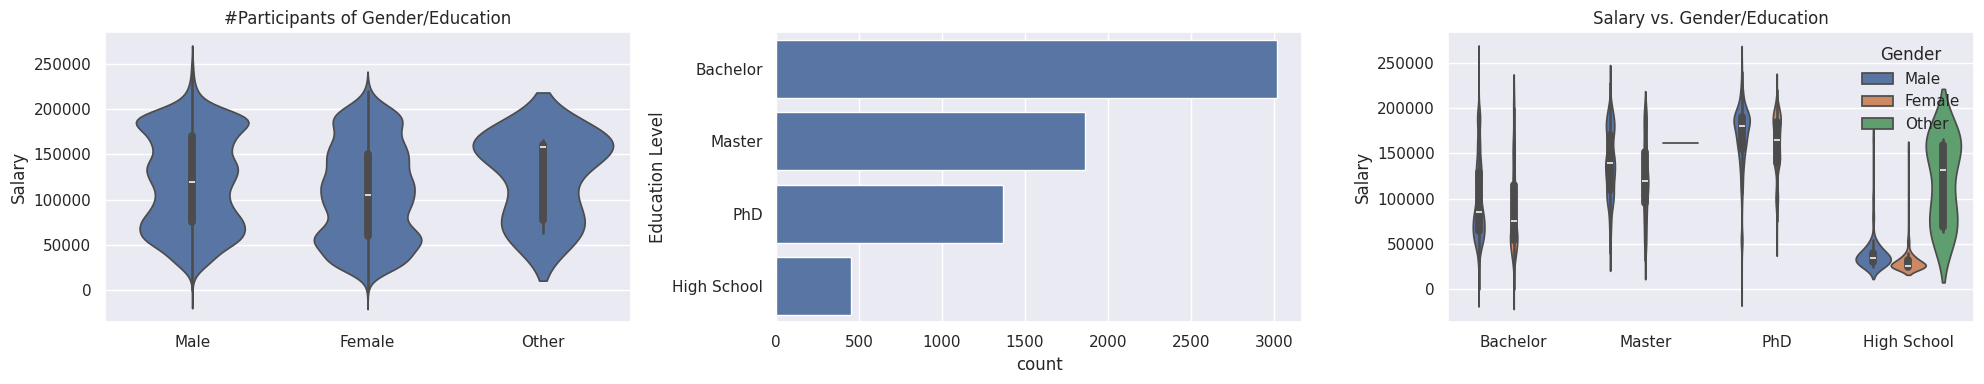

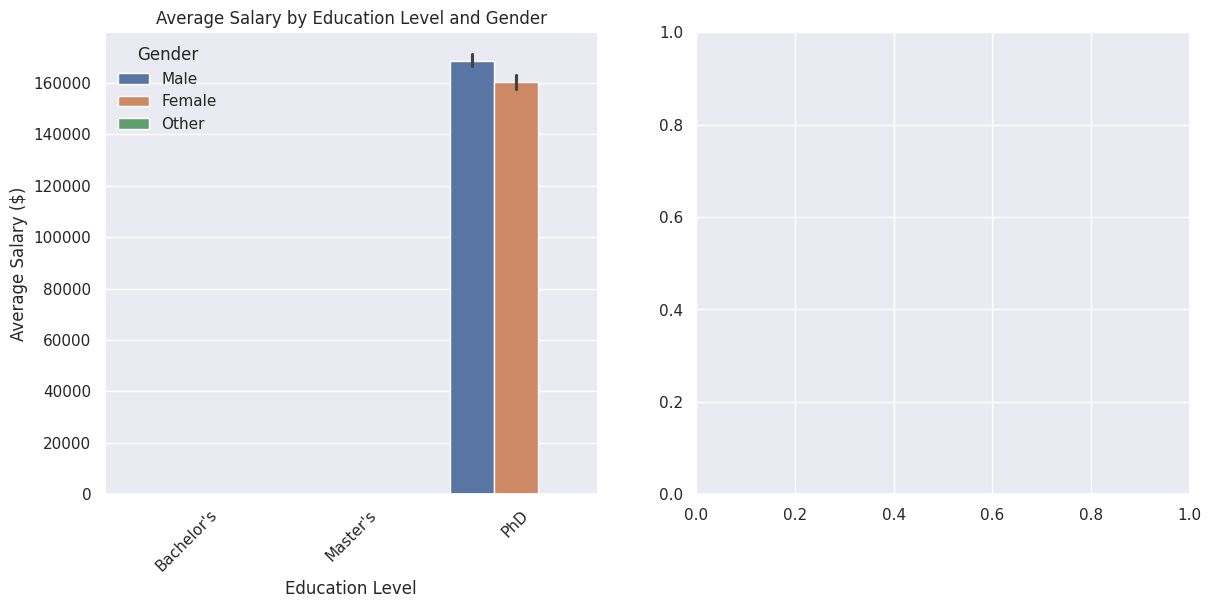

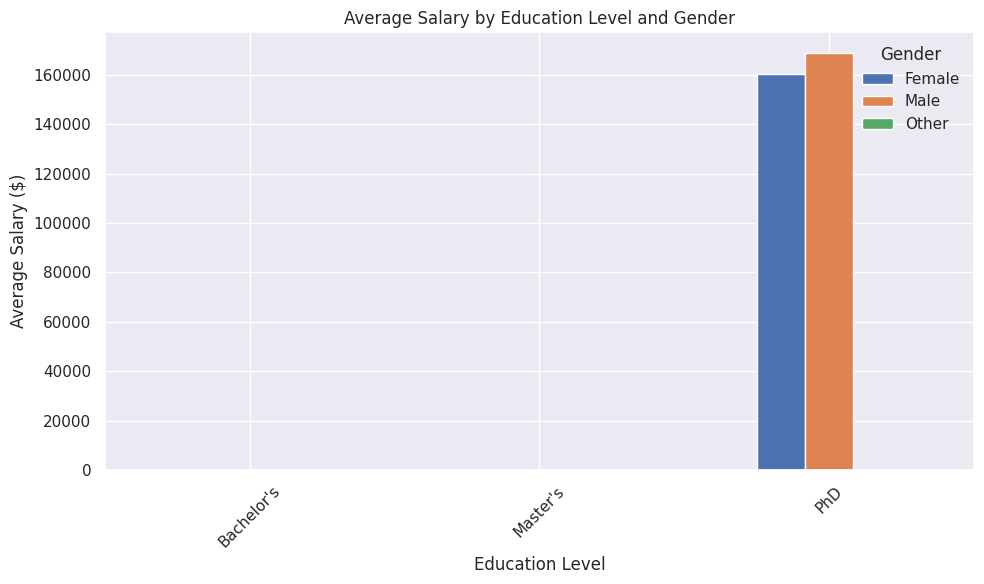

Salary Statistics by Education Level:



,mean,median,std,count
Education Level,,,,
PhD,165651.457999,170000.0,34339.751664,1369
Master,130112.056452,130000.0,40640.818933,1860
Bachelor,95082.908640,80000.0,44091.790154,3021
High School,36706.694196,30000.0,22549.129999,448


In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

g = sns.violinplot(x='Gender', y='Salary', data=salary_data, ax=axes[0])
g.set(title='Salary vs. Gender', xlabel=None)

edu_counts = salary_data['Education Level'].value_counts()
#g = sns.countplot(x='Gender', hue='Education Level', data=salary_data, ax=axes[1])
sns.countplot(y='Education Level', data=salary_data, order=edu_counts.index, ax=axes[1])
g.set(title='#Participants of Gender/Education', xlabel=None)

g = sns.violinplot(x='Education Level', y='Salary', hue='Gender', data=salary_data, ax=axes[2])
g.set(title='Salary vs. Gender/Education', xlabel=None)
plt.tight_layout()


# Gender and Education Level Combined
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Education Level', y='Salary', hue='Gender', data=salary_data, order=['Bachelor\'s', 'Master\'s', 'PhD'])
plt.title('Average Salary by Education Level and Gender')
plt.xlabel('Education Level')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
gender_edu = salary_data.groupby(['Gender', 'Education Level'])['Salary'].mean().reset_index()
gender_edu_pivot = gender_edu.pivot(index='Education Level', columns='Gender', values='Salary')
gender_edu_pivot = gender_edu_pivot.reindex(['Bachelor\'s', 'Master\'s', 'PhD'])
gender_edu_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Average Salary by Education Level and Gender')
plt.xlabel('Education Level')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Education level-based salary statistics
edu_salary = salary_data.groupby('Education Level')['Salary'].agg(['mean', 'median', 'std', 'count'])
print("Salary Statistics by Education Level:\n")
edu_salary.sort_values(by='mean', ascending=False)

Considering the job titles, I collected the most popular ten job titles for both male and female. Then, I calculated the difference in the number of participants and made a bar chart. The chart shows that in the jobs "marketing coordinator", "marketing manager", "human resource manager", and "full stack engineer", the number of female participants is higher than the number of male participants.

Then, I made a box plot for the range of salary for all the popular jobs. We can see that the median salary of three of the above-mentioned "female-most" jobs ("marketing coordinator", "marketing manager", and "human resource manager") is relatively lower than the other jobs. In addition, in most jobs, the median salary of female is lower than that of male. The only exception is "project manager".

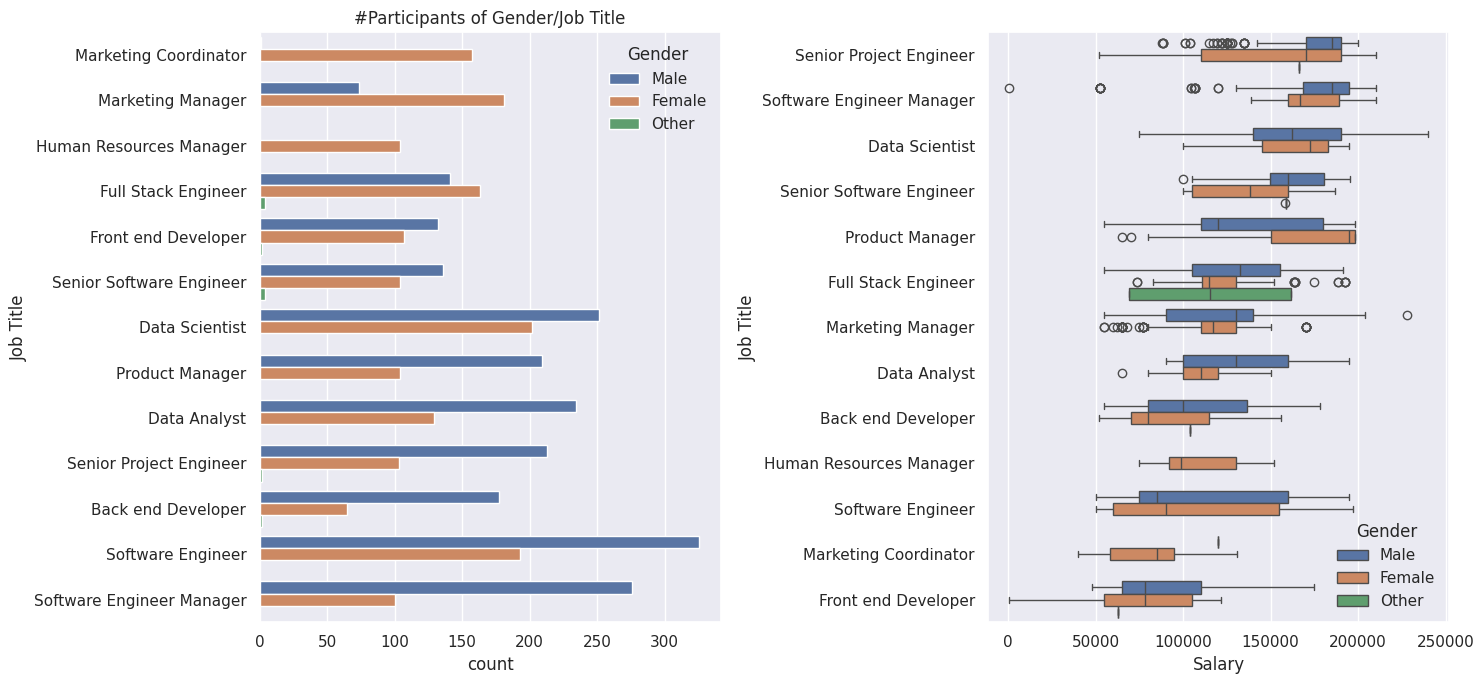

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# find the most popular jobs for both male and female
male_pop_jobs = salary_data[salary_data['Gender']=='Male']['Job Title'].value_counts()[:10].index
female_pop_jobs = salary_data[salary_data['Gender']=='Female']['Job Title'].value_counts()[:10].index
t = set(list(male_pop_jobs)+list(female_pop_jobs))

# calculate the #participants and sort the jobs in the order of different of #participants
job_count_diff = []
for e in t:
    job_data = salary_data[salary_data['Job Title']==e]
    dc = job_data[job_data['Gender']=='Male'].shape[0] - job_data[job_data['Gender']=='Female'].shape[0]
    job_count_diff.append([e, dc])
job_count_diff.sort(key = lambda x: x[1])

# plot the bar chart for #participants
both_pop_jobs_data = salary_data[salary_data['Job Title'].isin(t)]
g = sns.countplot(y='Job Title', hue='Gender', data=both_pop_jobs_data, order=[e[0] for e in job_count_diff], ax=axes[0])
g.set(title='#Participants of Gender/Job Title')

# -------------

# plot the box plot for the salary
high_pay_jobs = both_pop_jobs_data.groupby('Job Title')['Salary'].median().sort_values(ascending=False).index
sns.boxplot(y="Job Title", x="Salary", data=both_pop_jobs_data, order=high_pay_jobs, hue='Gender', ax=axes[1])
plt.tight_layout()


# **4.1 Descriptive Statistics**

Compute summary statistics for different demographic groups. Look at mean, median, standard deviation, and quartiles for features and the target variable across various groups.


**Interpretation of the Results:**

For the 'Female' group:

* Count: 3013 observations
* Mean age: Approximately 32.63 years
* Median age: 31 years
* Standard deviation: Approximately 6.98 years

For the 'Male' group:

* Count: 3671 observations
* Mean age: Approximately 34.42 years
* Median age: 32 years
* Standard deviation: Approximately 7.98 years

For the 'Other' group:

* Count: 14 observations
* Mean age: Approximately 39.57 years
* Median age: 37 years
* Standard deviation: Approximately 13.38 years


These statistics provide insights into the age distribution within each gender group, helping to understand the central tendency and variability of ages across different gender categories.

In [14]:
# Group the DataFrame by 'Gender' and select the 'Age' column
gender_groups = salary_data.groupby('Gender')['Age']

# Calculate summary statistics for each gender group (count, mean, median, std)
summary_statistics = gender_groups.agg(['count', 'mean', 'median', 'std'])

# Display the summary statistics
print("Summary Statistics for Age by Gender:")
print(summary_statistics)

Summary Statistics for Age by Gender:
        count       mean  median        std
Gender                                     
Female   3013  32.626286    31.0   6.976178
Male     3671  34.418415    32.0   7.979936
Other      14  39.571429    37.0  13.380320


# **4.2. Hypothesis Testing**

Formulate null and alternative hypotheses and perform hypothesis tests to determine if there is enough evidence to reject the null hypothesis. Common tests include t-tests, chi-square tests, ANOVA.


**Example: Independent Two-Sample T-Test**

**Objective:**

Test whether there is a significant difference in the average salary between two groups (e.g., Group A and Group B).

**Hypotheses:**

Null Hypothesis (H0): The mean salary of Group A is equal to the mean salary of Group B.

Alternative Hypothesis (H1): The mean salary of Group A is different from the mean salary of Group B.

**Here's an interpretation of the results:**

T-Statistic: 10.49

P-Value: 1.53e-25 (very close to zero)


The t-test results in a very low p-value (much smaller than the significance level of 0.05), indicating strong evidence against the null hypothesis. The null hypothesis assumes no difference in salaries between male and female groups. Since the p-value is extremely low, we reject the null hypothesis. Therefore, there is enough statistical evidence to suggest a significant difference in salaries between genders.

In [15]:
# Extract salaries for each gender group
salary_data['Salary'] = pd.to_numeric(salary_data['Salary'], errors='coerce')
salary_data.dropna(subset=['Salary'], inplace=True)
male_salaries = salary_data[salary_data['Gender'] == 'Male']['Salary']
female_salaries = salary_data[salary_data['Gender'] == 'Female']['Salary']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(male_salaries, female_salaries)

# Print results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Set significance level
alpha = 0.05

# Interpret the results
if p_value < alpha:
    print("\nReject the null hypothesis. \nThere is enough evidence to suggest a significant difference in salaries between genders.")
else:
    print("Fail to reject the null hypothesis. \nThere is not enough evidence to suggest a significant difference in salaries between genders.")


T-Statistic: 10.489305680117718
P-Value: 1.5264743340303035e-25

Reject the null hypothesis. 
There is enough evidence to suggest a significant difference in salaries between genders.


# **4.3 Effect Size:**

To understand the practical significance of the observed salary difference between genders, we can calculate Cohen's d, an effect size measure. Cohen's d indicates the magnitude of the difference, with common interpretations as follows:

*   **Small effect:** 0.2 <= |d| < 0.5
*   **Medium effect:** 0.5 <= |d| < 0.8
*   **Large effect:** |d| >= 0.8

A small effect suggests a modest impact, a medium effect indicates a moderate impact, and a large effect signifies a substantial impact.

The calculated Cohen's d value is 0.2578, suggesting a small effect size. In practical terms this means that the observed difference in salaries between genders is small and may not have substantial practical significance. Effect sizes provide valuable context for interpreting the magnitude of observed differences beyond statistical significance.


Calculation for Cohens d:

In [16]:
# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(male_salaries, female_salaries)

# Calculate Cohen's d
mean_difference = male_salaries.mean() - female_salaries.mean()
pooled_std_dev = ((len(male_salaries) - 1) * male_salaries.var() + (len(female_salaries) - 1) * female_salaries.var()) / (len(male_salaries) + len(female_salaries) - 2)
cohen_d = mean_difference / (pooled_std_dev ** 0.5)

# Print Cohen's d
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.2578536030939307


# **4.4. Theil Index**


Description: The Theil Index measures the overall inequality in a dataset, including both within-group and between-group disparities.

Calculation: It considers entropy within groups and overall entropy.

Interpretation: Higher values indicate higher inequality or bias.

**Results:**

**Theil Index for Male (8.11):** This value indicates the level of inequality in salaries among males. A higher Theil Index suggests greater inequality in salary distribution within the male group.

**Theil Index for Female (7.88):** Similarly, this value represents the level of inequality in salaries among females. A higher Theil Index implies more significant disparities in salary distribution within the female group.

**Comparing these values**, the Theil Index for males (8.11) is slightly higher than that for females (7.88). This suggests that there may be a slightly higher level of inequality in salary distribution among males compared to females in the given dataset.

Calculating the Theil index:

In [17]:
# Calculate Theil Index for each group
theil_male = entropy(male_salaries)
theil_female = entropy(female_salaries)

# Display Theil Index values
print(f"Theil Index for Male: {theil_male}")
print(f"Theil Index for Female: {theil_female}")


Theil Index for Male: 8.109797060138703
Theil Index for Female: 7.883871535489255


# **4.5. Demographic Parity**

Demographic parity focuses on ensuring that the percentage of positive outcomes is roughly equal across different groups.

 It seeks to ensure that decisions made by the model are not influenced by protected attributes like gender, race, etc.


**Results:**

**Demographic Parity for Male (0.597):** This value indicates that approximately 59.7% of males in the dataset have salaries above the $100,000 threshold.


**Demographic Parity for Female (0.522):** This value indicates that approximately 52.2% of females in the dataset have salaries above the $100,000 threshold.
Comparison:

The demographic parity for males is higher (0.597) compared to females (0.522).
This suggests that a larger proportion of males in the dataset have salaries above $100,000 compared to females.

Calculating Disparity:

In [18]:
# Set a salary threshold
salary_threshold = 100000

# Create a binary outcome variable indicating whether the salary is above the threshold
salary_data.loc[:, 'Outcome'] = (salary_data['Salary'] > salary_threshold).astype(int)

# Assuming 'Male' and 'Female' are the gender groups
male_data = salary_data[salary_data['Gender'] == 'Male']
female_data = salary_data[salary_data['Gender'] == 'Female']

# Calculate Demographic Parity
parity_male = male_data['Outcome'].mean()
parity_female = female_data['Outcome'].mean()

# Display the results
print(f"Demographic Parity for Male: {parity_male}")
print(f"Demographic Parity for Female: {parity_female}")

Demographic Parity for Male: 0.5965676927267775
Demographic Parity for Female: 0.5217391304347826


# **4.6. Disparate Impact**

Disparate impact measures the difference in outcomes between different groups, such as genders. It's commonly used in the context of hiring, lending, or any decision-making process where fairness is critical. A value close to 1 indicates fairness, while values significantly deviating from 1 may suggest disparate impact.


**Interpretation of the result:**

**For Males:**The Disparate Impact is 1.059, suggesting a slightly higher outcome rate compared to the overall dataset. It could mean that, on average, males are more likely to be predicted as having a salary above the threshold.


**For Females:** The Disparate Impact is 0.926, indicating a slightly lower outcome rate compared to the overall dataset. It could mean that, on average, females are less likely to be predicted as having a salary above the threshold.


It's important to note that while Disparate Impact provides a quantitative measure, interpreting its practical significance also requires considering the context of the specific application and any legal or ethical thresholds that may be in place.







Calculating Disparate Impact:

In [19]:

# Calculate Disparate Impact for Male and Female groups
disparate_impact_male = male_data['Outcome'].mean() / salary_data['Outcome'].mean()
disparate_impact_female = female_data['Outcome'].mean() / salary_data['Outcome'].mean()

# Display the results
print(f"Disparate Impact for Male: {disparate_impact_male}")
print(f"Disparate Impact for Female: {disparate_impact_female}")


Disparate Impact for Male: 1.0593346781240602
Disparate Impact for Female: 0.9264604177232698


In [20]:
# Calculate gender pay gap overall
male_avg = salary_data[salary_data['Gender'] == 'Male']['Salary'].mean()
female_avg = salary_data[salary_data['Gender'] == 'Female']['Salary'].mean()
pay_gap = (male_avg - female_avg) / male_avg * 100

print(f"Average male salary: ${male_avg:.2f}")
print(f"Average female salary: ${female_avg:.2f}")
print(f"Gender pay gap: {pay_gap:.2f}% (women earn {100-pay_gap:.2f}% of men's salary)")

# Calculate gender pay gap by education level
gender_edu_gap = salary_data.groupby(['Education Level', 'Gender'])['Salary'].mean().unstack()
gender_edu_gap['Pay Gap (%)'] = (gender_edu_gap['Male'] - gender_edu_gap['Female']) / gender_edu_gap['Male'] * 100
gender_edu_gap['Female % of Male'] = 100 - gender_edu_gap['Pay Gap (%)']

print("\nGender Pay Gap by Education Level:")
gender_edu_gap

Average male salary: $121395.70
Average female salary: $107889.00
Gender pay gap: 11.13% (women earn 88.87% of men's salary)

Gender Pay Gap by Education Level:


Gender,Female,Male,Other,Pay Gap (%),Female % of Male
Education Level,,,,,
Bachelor,89165.219533,98971.768513,NaN,9.908431,90.091569
High School,30756.047809,39380.751351,119949.333333,21.900810,78.099190
Master,122694.542135,140060.592405,161393.000000,12.398955,87.601045
PhD,160266.292339,168711.071019,NaN,5.005468,94.994532


Visualizing pay gap:

In [21]:
# Create experience groups
exp_bins = [0, 3, 6, 10, 15, 30]
exp_labels = ['0-2', '3-5', '6-9', '10-14', '15+']
salary_data['Experience_Group'] = pd.cut(salary_data['Years of Experience'], bins=exp_bins, labels=exp_labels, right=False)

<ipython-input-22-33c62b25c16e>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_exp_gap = salary_data.groupby(['Experience_Group', 'Gender'])['Salary'].mean().unstack()


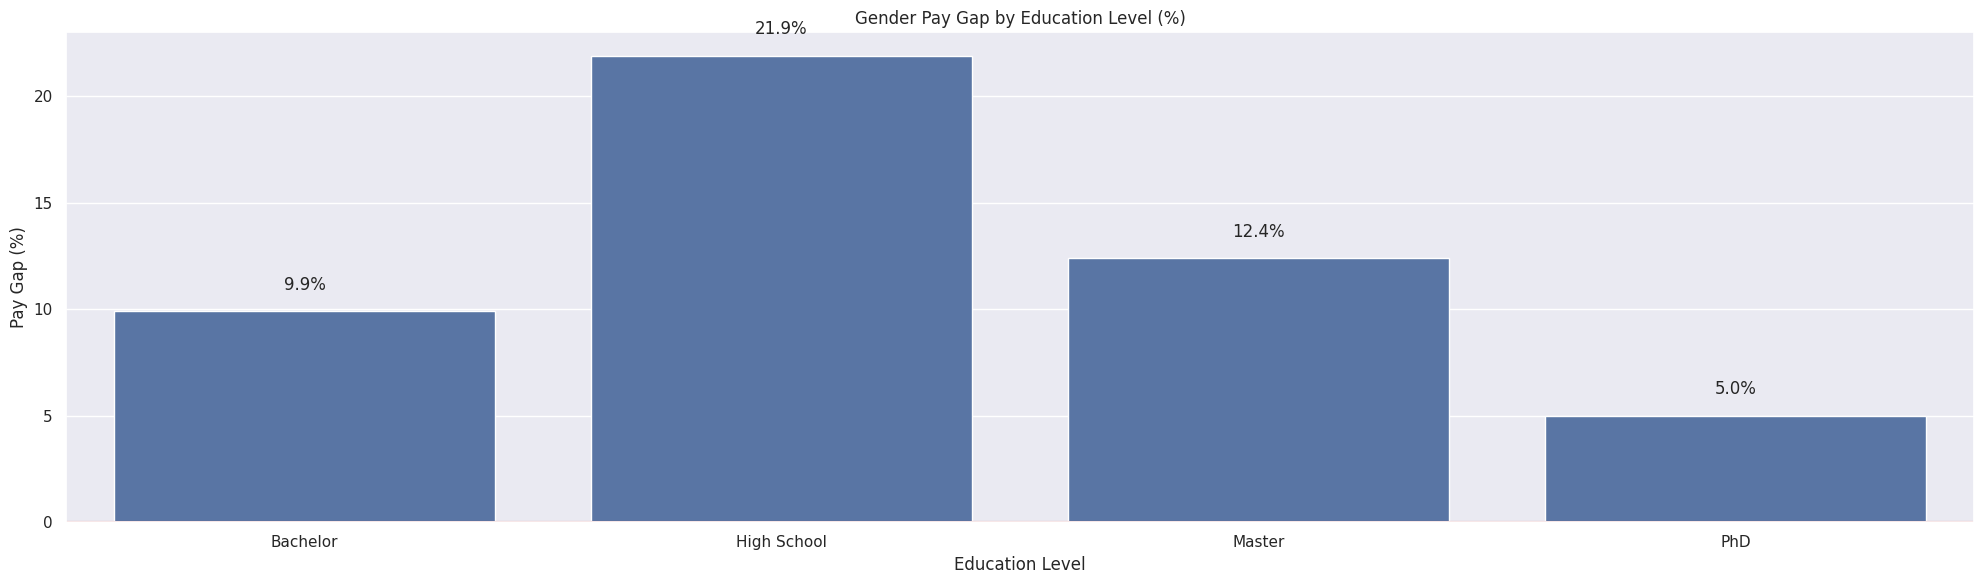

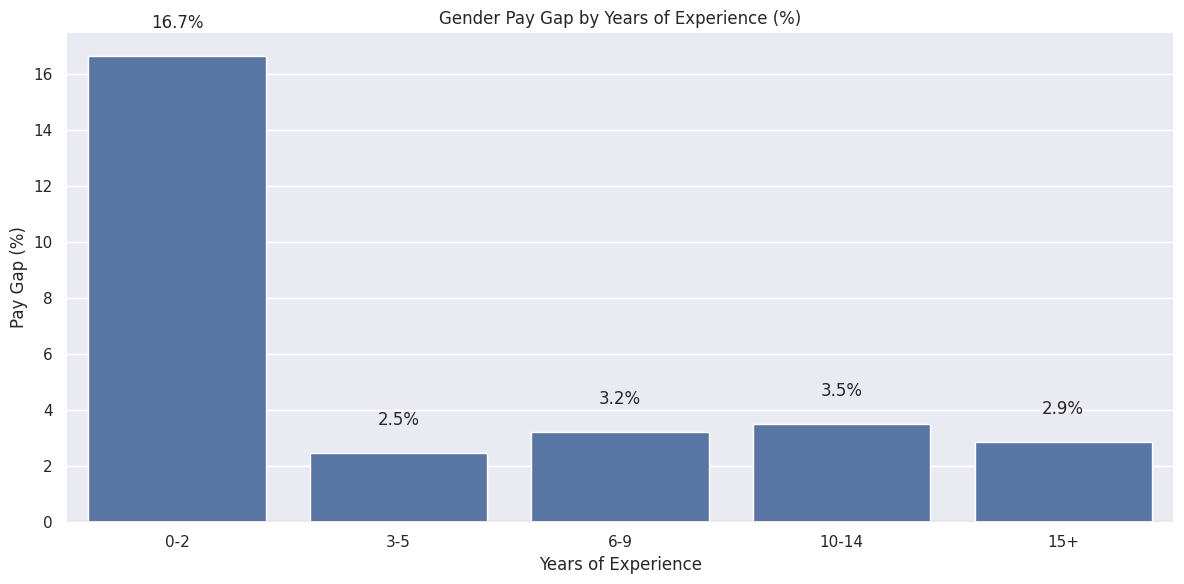

In [22]:
# Visualize gender pay gap by education level
plt.figure(figsize=(20, 6))
sns.barplot(x=gender_edu_gap.index, y=gender_edu_gap['Pay Gap (%)'])
plt.title('Gender Pay Gap by Education Level (%)')
plt.xlabel('Education Level')
plt.ylabel('Pay Gap (%)')
plt.axhline(y=0, color='r', linestyle='-')

# Add value labels
for i, v in enumerate(gender_edu_gap['Pay Gap (%)']):
    plt.text(i, v + (1 if v > 0 else -2), f"{v:.1f}%", ha='center')

plt.tight_layout()


# Gender pay gap by experience level
gender_exp_gap = salary_data.groupby(['Experience_Group', 'Gender'])['Salary'].mean().unstack()
gender_exp_gap['Pay Gap (%)'] = (gender_exp_gap['Male'] - gender_exp_gap['Female']) / gender_exp_gap['Male'] * 100
gender_exp_gap = gender_exp_gap.reindex(exp_labels)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=gender_exp_gap.index, y=gender_exp_gap['Pay Gap (%)'])
plt.title('Gender Pay Gap by Years of Experience (%)')
plt.xlabel('Years of Experience')
plt.ylabel('Pay Gap (%)')
plt.axhline(y=0, color='r', linestyle='-')

# Add value labels
for i, v in enumerate(gender_exp_gap['Pay Gap (%)']):
    plt.text(i, v + (1 if v > 0 else -2), f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

<hr>

# **5. Correlation Analysis and Regression Models**

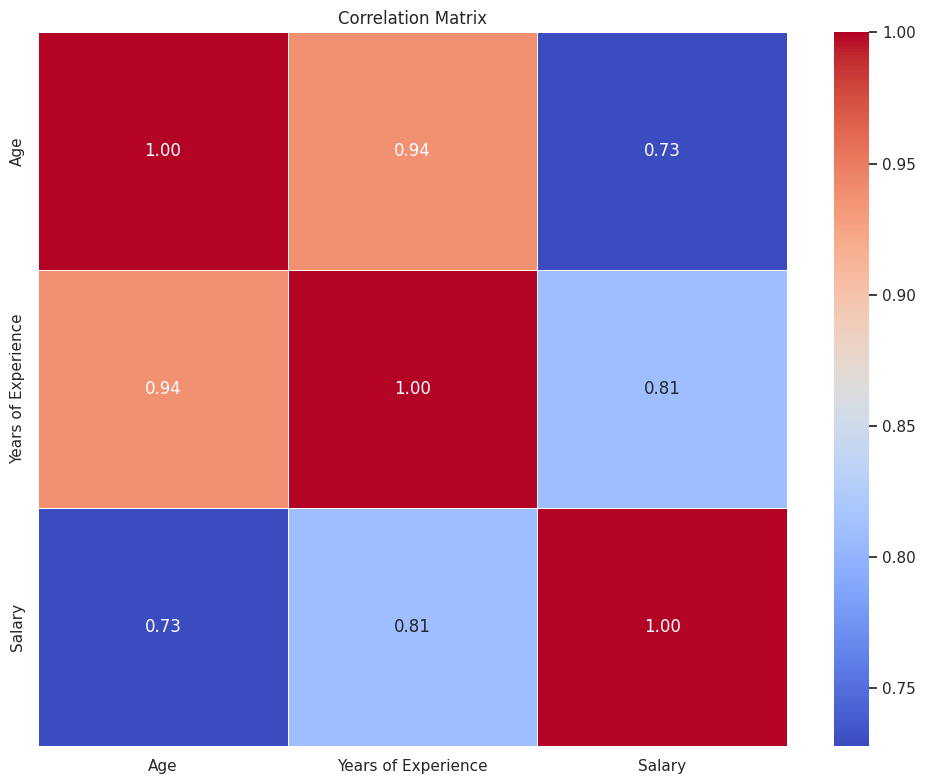

Correlation Matrix:


,Age,Years of Experience,Salary
Age,1.000000,0.937683,0.728061
Years of Experience,0.937683,1.000000,0.809060
Salary,0.728061,0.809060,1.000000


In [23]:
# Correlation between numerical variables
numeric_salary_data = salary_data[['Age', 'Years of Experience', 'Salary']]
correlation = numeric_salary_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
correlation

# Data Preprocessing

In [24]:
# Check for missing values
missing_values = salary_data.isnull().sum()
print("Missing values per column:")
print(missing_values)
salary_data = salary_data.dropna()

Missing values per column:
Age                     0
Gender                  0
Education Level         0
Job Title               0
Years of Experience     0
Salary                  0
Outcome                 0
Experience_Group       29
dtype: int64


#5. Machine Learning Models:

### Linear Regression:

In [25]:


# Use years of experience to predict salary
X = salary_data[['Years of Experience']]
y = salary_data['Salary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model intercept: {model.intercept_:.2f}")
print(f"Model coefficient (Years of Experience): {model.coef_[0]:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Model intercept: 56104.72
Model coefficient (Years of Experience): 7377.24
Mean Squared Error: 924162184.22
R² Score: 0.66


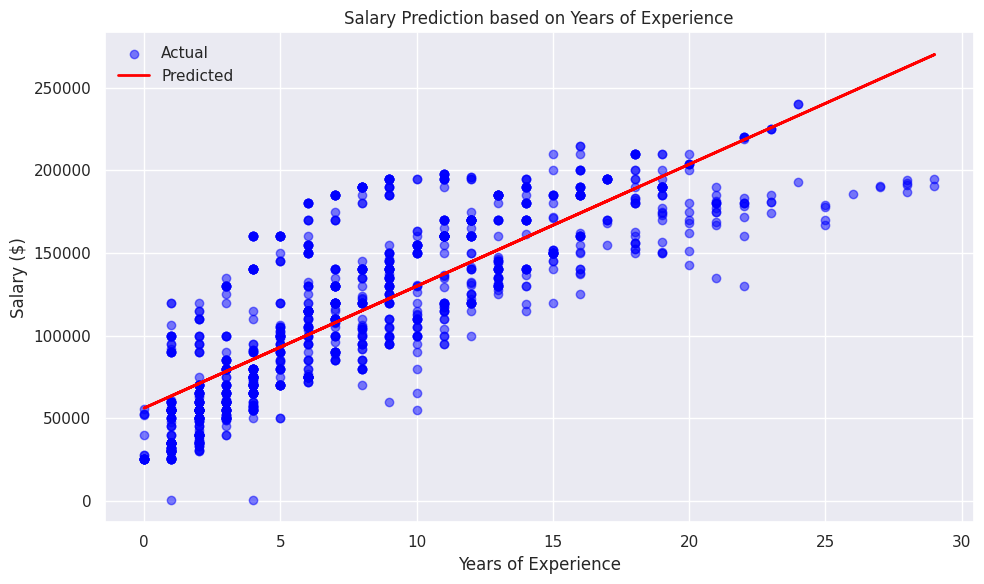

Salary prediction formula: Salary = 56104.72 + 7377.24 × Years of Experience


In [26]:
# Visualize regression results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.title('Salary Prediction based on Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary ($)')
plt.legend()
plt.tight_layout()
plt.show()

# Create a formula for salary prediction
formula = f"Salary = {model.intercept_:.2f} + {model.coef_[0]:.2f} × Years of Experience"
print(f"Salary prediction formula: {formula}")

In [27]:
# Select features for prediction
X = salary_data[['Age', 'Years of Experience']]
y = salary_data['Salary']

# Add gender as a feature
# Convert gender to numeric (0 for Female, 1 for Male)
X_with_gender = X.copy()
X_with_gender['Gender_Male'] = (salary_data['Gender'] == 'Male').astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_with_gender, y, test_size=0.2, random_state=42
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model intercept: {model.intercept_:.2f}")
print(f"Model coefficients:")
print(f"  - Age: {model.coef_[0]:.2f}")
print(f"  - Years of Experience: {model.coef_[1]:.2f}")
print(f"  - Gender (Male=1): {model.coef_[2]:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Model intercept: 106074.53
Model coefficients:
  - Age: -2176.55
  - Years of Experience: 9940.80
  - Gender (Male=1): 4563.96
Mean Squared Error: 872740792.83
R² Score: 0.68


### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Use the same features as linear regression
X = salary_data[['Age', 'Years of Experience']].copy()
X_with_gender = X.copy()
X_with_gender['Gender_Male'] = (salary_data['Gender'] == 'Male').astype(int)
y = salary_data['Salary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_with_gender, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest - Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest - R² Score: {rf_r2:.2f}")

Random Forest - Mean Squared Error: 403315606.03
Random Forest - R² Score: 0.85


Included another Random Forest model which used 'Education Level' as a feature, to test significance of said feauture in determining salary

In [30]:
# One-hot encode Education Level
edu_dummies = pd.get_dummies(salary_data['Education Level'], prefix='Edu', drop_first=True)

# Build the feature set
X = salary_data[['Age', 'Years of Experience']].copy()
X['Gender_Male'] = (salary_data['Gender'] == 'Male').astype(int)

# Add one-hot encoded education columns
X = pd.concat([X, edu_dummies], axis=1)

# Target variable
y = salary_data['Salary']

In [31]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest (with Education) - MSE: {rf_mse:.2f}")
print(f"Random Forest (with Education) - R² Score: {rf_r2:.2f}")

Random Forest (with Education) - MSE: 276772278.09
Random Forest (with Education) - R² Score: 0.90


Increased R² score suggests 'Education Level' may have more influence on salary than the other features

<ipython-input-32-f2abc1fafa71>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


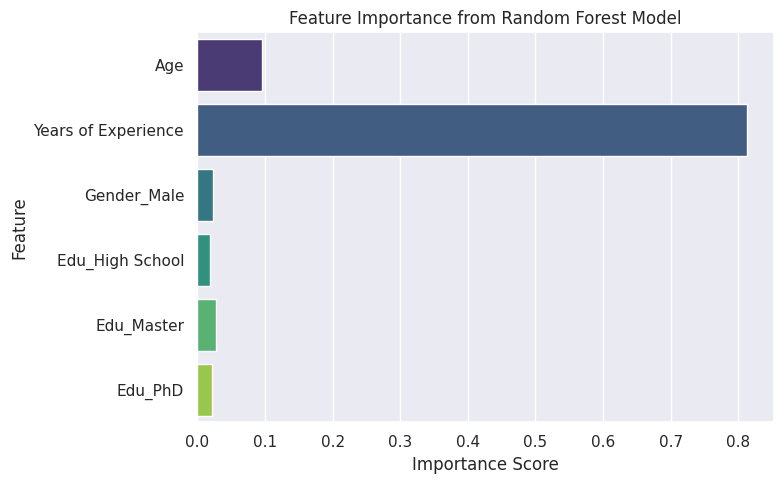

In [32]:
# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Feature importance further supports that education level has significant influence on an individual's salary, though not as big of an influence as the individual's years of experience.

<hr>

In [33]:
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Outcome,Experience_Group
0,32,Male,Bachelor,Software Engineer,5,90000.0,0,3-5
1,28,Female,Master,Data Analyst,3,65000.0,0,3-5
2,45,Male,PhD,Senior Manager,15,150000.0,1,15+
3,36,Female,Bachelor,Sales Associate,7,60000.0,0,6-9
4,52,Male,Master,Director,20,200000.0,1,15+


In [34]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender', 'Education Level', 'Job Title']
X = salary_data.drop(['Salary', 'Outcome', 'Experience_Group'], axis=1)
y = salary_data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since our features don't have values that range widely in scale, standardization/normalization are not necessary here

We're gonna need to encode our categorical variables to ensure all the features are able to be input into our machine learning models

In [35]:
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

X_train = X_train.drop(columns=categorical_columns).join(X_train_encoded)
X_test = X_test.drop(columns=categorical_columns).join(X_test_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Lets see if some hyperparameter tuning will help

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]}

knn = KNeighborsClassifier()

In [38]:
grid_search_knn = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5,refit=True)

In [39]:
grid_search_knn.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [40]:
knn_pred = grid_search_knn.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score
print("Accuracy Score KNN: ",accuracy_score(y_test, knn_pred))
mse = mean_squared_error(y_test, knn_pred)
r2 = r2_score(y_test, knn_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Accuracy Score KNN:  0.7646176911544228
Mean Squared Error: 125974268.27
R² Score: 0.95


Let's see how the model performs when using a specific subset of features that we saw to be highly correlated within our visualizations

In [42]:

X_train_removal_1 = X_train.drop(columns=['Gender_Male', "Gender_Other"], axis=1)
X_test_removal_1 = X_test.drop(columns=['Gender_Male', "Gender_Other"], axis=1)

In [43]:
knn_new = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3, p=1, weights='distance')
knn_new.fit(X_train_removal_1, y_train)
knn_new_pred = knn_new.predict(X_test_removal_1)

In [44]:
print("Accuracy Score KNN: ",accuracy_score(y_test, knn_new_pred))
mse = mean_squared_error(y_test, knn_new_pred)
r2 = r2_score(y_test, knn_new_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Accuracy Score KNN:  0.7481259370314842
Mean Squared Error: 140724437.89
R² Score: 0.95


<hr>

Neural Network With PyTorch

In [45]:
print(salary_data)

      Age  Gender Education Level              Job Title  Years of Experience    Salary  Outcome Experience_Group
0      32    Male        Bachelor      Software Engineer                    5   90000.0        0              3-5
1      28  Female          Master           Data Analyst                    3   65000.0        0              3-5
2      45    Male             PhD         Senior Manager                   15  150000.0        1              15+
3      36  Female        Bachelor        Sales Associate                    7   60000.0        0              6-9
4      52    Male          Master               Director                   20  200000.0        1              15+
...   ...     ...             ...                    ...                  ...       ...      ...              ...
6699   49  Female             PhD  Director of Marketing                   20  200000.0        1              15+
6700   32    Male     High School        Sales Associate                    3   50000.0 

We need to make the data usable for a Tensor Dataset, and since Job_Title is a high cardinality feature, instead of one-hot encoding this time we'll try label encoding.

In [46]:
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Gender', 'Education Level', 'Job Title']
low_cardinality = ['Gender', 'Education Level']
high_cardinality = ['Job Title']

#One-hot encode low-cardinality features
X_low_cat = encoder.fit_transform(salary_data[low_cardinality])
X_low_cat_df = pd.DataFrame(X_low_cat, columns=encoder.get_feature_names_out(low_cardinality),index=salary_data.index)

#Label encode high-cardinality features
label_encoders = {}
for col in high_cardinality:
    le = LabelEncoder()
    salary_data[col + '_Encoded'] = le.fit_transform(salary_data[col])
    label_encoders[col] = le

# Drop original categorical columns
X = salary_data.drop(columns=categorical_columns)
X = X.drop(columns=['Outcome','Experience_Group','Salary'])
X = X.join(X_low_cat_df)

X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
y = salary_data.iloc[:,5].astype('float32').to_numpy().reshape(-1, 1)

from sklearn.preprocessing import StandardScaler

X.columns = X.columns.astype(str)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)

print(X.columns)




Index(['Age', 'Years of Experience', 'Job Title_Encoded', 'Gender_Male', 'Gender_Other', 'Education Level_High School', 'Education Level_Master', 'Education Level_PhD'], dtype='object')


<ipython-input-46-14dc7d11f2f2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_data[col + '_Encoded'] = le.fit_transform(salary_data[col])


In [47]:
from torch.utils.data import DataLoader

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2,shuffle=True)

In [48]:
import torch.nn as nn
import torch.optim as optim
#Starts with 8 because we have 8 features
#Ends with 1 because we are dealing with regression which
#is one continous value
model = nn.Sequential(nn.Linear(8, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))


#Optimizer and loss function

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [49]:
for epoch in range(100):
    for batch_inputs, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

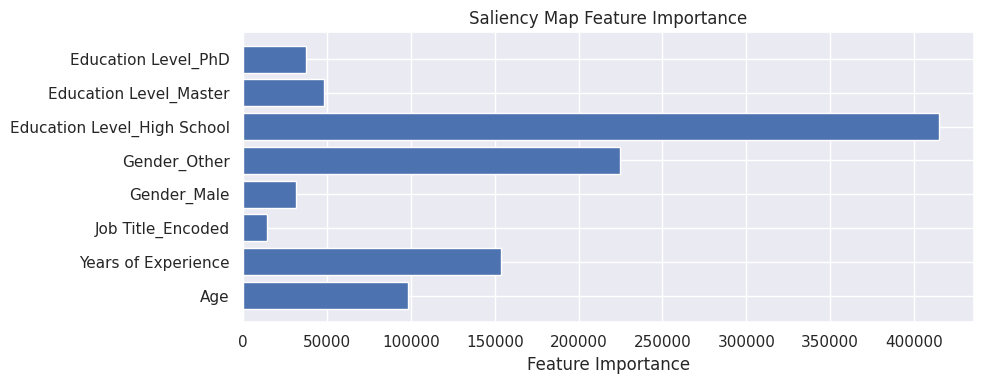

In [50]:
X_tensor.requires_grad = True
outputs = model(X_tensor)
loss = criterion(outputs, y_tensor)
loss.backward()

feature_importance = X_tensor.grad.abs().mean(dim=0)

importance_vals = feature_importance.detach().numpy()
plt.figure(figsize=(10, 4))
plt.barh(X.columns, importance_vals)
plt.xlabel("Feature Importance")
plt.title("Saliency Map Feature Importance")
plt.tight_layout()
plt.show()

"Other" can be neglected as it has so few datapoints.

The graph illustrates that the most important feature by and far for determining one's salary is if they have or don't have a high school degree.

And then from there Years of Experience takes the second most priority which lines up with our previous findings

In [51]:
model.eval()  # turn off dropout/batchnorm (not used here, but good habit)
with torch.no_grad():
    predictions = model(X_tensor)
    mse = criterion(predictions, y_tensor)
    print(f"Final MSE: {mse.item():.4f}")


Final MSE: 1071164928.0000


In [52]:
from sklearn.metrics import r2_score

y_pred = model(X_tensor).detach().numpy()
y_true = y_tensor.numpy()
r2 = r2_score(y_true, y_pred)
print(f"R²: {r2:.4f}")

R²: 0.6142


# **6. Limitations and Future Work**

### Limitations of the Analysis:

*   **Data Duplication:** The dataset contains a significant number of duplicate entries, which may skew the analysis. Although duplicates were kept to avoid losing a large portion of the data, their presence should be considered when interpreting the results.
*   **Survey Focus:** The survey appears to be heavily focused on the IT industry, which limits the generalizability of the findings to other sectors.
*   **Gender Imbalance:** There is a slight gender imbalance in the dataset, with more male participants than female participants. This could potentially affect the gender-based analysis.
*   **Limited Factors:** The analysis primarily focuses on gender, education level, years of experience, and job title. Other factors such as company size, location, and specific skills could also influence salary.
*   **Correlation vs. Causation:** The analysis identifies correlations between variables but does not establish causation. For example, while age and salary are correlated, this does not necessarily mean that age directly causes higher salaries.
*   **Static Data:** The data represents a snapshot in time and does not account for changes in salary over time or career progression.
*   **Theil Index Interpretation:** The Theil index measures inequality but doesn't specify the reasons behind it. Further investigation is needed to understand the factors contributing to salary disparities.
*   **Demographic Parity Considerations:** Achieving demographic parity may not always be desirable, especially if it requires compromising on merit or qualifications. It's essential to consider the ethical implications of interventions aimed at achieving demographic parity.

